# Two-Stage Object detection w/ Freeze Learning & Fine-tuning
For this approach, it will be used a pretrained DensetNet201 as a backbone for a F-RCNN model for object detection, to which it will be applied freeze learning and fine-tuning to our task.

In [1]:
import os

DATA_DIR = "../data/"
IMG_DIR = DATA_DIR + "/images/"
ANNOTATION_DIR = DATA_DIR + "/annotations/"
SPLITS_DIR = DATA_DIR + "/dl-split/"
OUT_DIR = "./out/two_stage_obj_det/"

os.makedirs(OUT_DIR, exist_ok=True)

SEED = 42

# Utility Function

In [2]:
import matplotlib.pyplot as plt
def plot_training_history(train_history, val_history, model_name, phase_name, out_dir):
    fig, (loss_ax, map_ax) = plt.subplots(figsize=(12, 8), nrows=2)
    fig.suptitle(f"{model_name} - {phase_name} History")
    loss_ax.set_title("Cross Entropy Loss")
    loss_ax.plot(train_history, label="train")
    loss_ax.legend(loc="best")

    map_ax.set_title("Classification mAP")
    map_ax.plot(val_history, label="val")
    map_ax.legend(loc="best")

    plt.tight_layout()

    fig.savefig(f"{out_dir}/{model_name}_{phase_name}_history.png", dpi=150, bbox_inches='tight')

    return fig

# Load Dataset

In [3]:
# Fetching pre-defined splits
train_split = []
test_split = []

with open(SPLITS_DIR + "/train.txt") as train_split_f:
    train_split = [line.strip("\n") for line in train_split_f.readlines()]

with open(SPLITS_DIR + "/test.txt") as test_split_f:
    test_split = [line.strip("\n") for line in test_split_f.readlines()]

In [4]:
# Label mapping
label_encode_map = {
    "background": 0,
    "trafficlight": 1,
    "speedlimit": 2,
    "crosswalk": 3,
    "stop": 4,
}

label_decode_map = {
    0: "background",
    1: "trafficlight",
    2: "speedlimit",
    3: "crosswalk",
    4: "stop",
}

# Split training dataset in a balanced manner

In [5]:
from utils.utils import parse_annotation

def get_annotations(split):
    annotations = {}
    for id in split:
        annotation = parse_annotation(f"{ANNOTATION_DIR}/{id}.xml", label_encode_map, return_biggest = True)
        annotation["labels"] = annotation["labels"][0]
        annotations[id] = annotation

    return annotations

annotations = get_annotations(train_split)

In [6]:
import pandas as pd
train_df = pd.DataFrame.from_dict(annotations, orient="index")
train_df

,width,height,labels,boxes,areas
road706,300.0,400.0,2,"[[135.0, 159.0, 177.0, 201.0]]",[1764.0]
road538,300.0,400.0,2,"[[115.0, 169.0, 149.0, 205.0]]",[1224.0]
road510,300.0,400.0,2,"[[89.0, 201.0, 133.0, 245.0]]",[1936.0]
road504,300.0,400.0,2,"[[92.0, 230.0, 139.0, 277.0]]",[2209.0]
road458,300.0,400.0,2,"[[67.0, 116.0, 139.0, 189.0]]",[5256.0]
...,...,...,...,...,...
road247,300.0,400.0,2,"[[139.0, 218.0, 156.0, 236.0]]",[306.0]
road253,300.0,400.0,2,"[[128.0, 87.0, 187.0, 144.0]]",[3363.0]
road535,300.0,400.0,2,"[[100.0, 254.0, 180.0, 334.0]]",[6400.0]
road284,300.0,400.0,2,"[[111.0, 133.0, 165.0, 187.0]]",[2916.0]


Label Ratios
1    0.086460
2    0.730832
3    0.104405
4    0.078303
Name: labels, dtype: float64


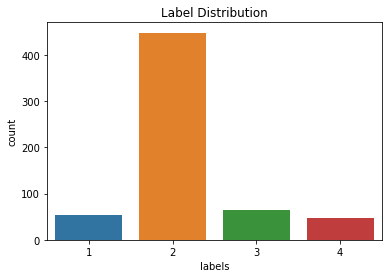

<Figure size 432x288 with 0 Axes>

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

print("Label Ratios")
label_ratios = (train_df["labels"].value_counts() / len(train_df["labels"])).sort_index()
print(label_ratios)

fig, ax = plt.subplots()
sns.countplot(data=train_df, x="labels", ax=ax, tick_label=["trafficlight", "speedlimit", "crosswalk", "stop"])
ax.set_title("Label Distribution")

plt.show()
plt.clf()

Train Label Ratios
2    0.732106
3    0.104294
1    0.085890
4    0.077710
Name: labels, dtype: float64
Validation Label Ratios
2    0.725806
3    0.104839
1    0.088710
4    0.080645
Name: labels, dtype: float64


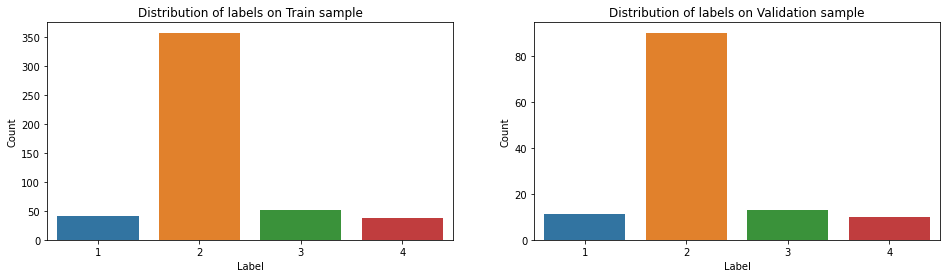

<Figure size 432x288 with 0 Axes>

In [8]:
# Maintain the ratios of labels across splits
train_sample = train_df.groupby("labels").sample(frac=0.8, random_state=SEED)
val_sample = train_df.loc[train_df.index.difference(train_sample.index)]

fig, (train_ax, val_ax) = plt.subplots(figsize=(16, 4), ncols=2)
for split, df, ax in zip(["Train", "Validation"], [train_sample, val_sample], [train_ax, val_ax]):
    sns.countplot(x=df["labels"], ax=ax)
    ax.set_title(f"Distribution of labels on {split} sample")
    ax.set_xlabel("Label")
    ax.set_ylabel("Count")
    
    print(f"{split} Label Ratios")
    print(pd.Series(df["labels"]).value_counts() / len(df["labels"]))
plt.show()
plt.clf()

In [9]:
from datasets.road_sign_dataset import RoadSignDataset

# Training dataset
training_data = RoadSignDataset(
    img_names=train_sample.index.tolist(),
    img_dir=IMG_DIR,
    annotation_dir=ANNOTATION_DIR,
    classes=label_encode_map,
    is_train=True,
    multilabel=False,
    obj_detection=True
)

# Validation dataset
validation_data = RoadSignDataset(
    img_names=val_sample.index.tolist(),
    img_dir=IMG_DIR,
    annotation_dir=ANNOTATION_DIR,
    classes=label_encode_map,
    is_train=True,
    multilabel=False,
    obj_detection=True
)

# Test dataset
testing_data = RoadSignDataset(
    img_names=test_split,
    img_dir=IMG_DIR,
    annotation_dir=ANNOTATION_DIR,
    classes=label_encode_map,
    is_train=False,
    multilabel=False,
    obj_detection=True
)

# Create Dataloaders

In [10]:
from torch.utils.data import DataLoader

BATCH_SIZE = 8 # Tested on 1050TI with 4GB (can load at least 64 as well, but doesn't make sense to use 64 with low amount of data)
NUM_WORKERS = 4

train_dataloader = DataLoader(
    dataset=training_data,
    #sampler=train_sampler,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS,
    shuffle=True,
    drop_last=True,
    collate_fn=training_data.collate_fn
)

val_dataloader = DataLoader(
    dataset=validation_data,
    #sampler=val_sampler,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS,
    shuffle=True,
    drop_last=True,
    collate_fn=training_data.collate_fn
)

test_dataloader = DataLoader(
    dataset=testing_data,
    batch_size=1,
    num_workers=NUM_WORKERS,
    shuffle=False,
    drop_last=False,
    collate_fn=testing_data.collate_fn
)

# Model Definition

In [11]:
from torchvision import models
from torch import nn
from torchvision.models.detection.anchor_utils import AnchorGenerator
from torchvision.models.detection.backbone_utils import (
    LastLevelMaxPool,
    BackboneWithFPN
)
from torchinfo import summary

MODEL_NAME = "FRCNN-Densenet201"
N_CLASSES = 4 + 1 # 4 target classes + background
"""_summary_
Adapted from fasterrcnn_resnet50_fpn at https://github.com/pytorch/vision/blob/c890a7e75ebeaaa75ae9ace4c203b7fc145df068/torchvision/models/detection/faster_rcnn.py
"""
def get_model(n_classes):
    backbone = models.densenet201(pretrained=True)
    
    return_layers = ["denseblock3", "denseblock4"] # ["denseblock1", "denseblock2", "denseblock3", "denseblock4"]
    return_layers = {k: str(v) for v, k in enumerate(return_layers)}
    #in_channel_list = [256, 512, 1024, 1024] # Densenet 121
    #in_channel_list = [256, 512, 1280, 1664] # Densenet 169
    in_channel_list = [1792, 1920] # [256, 512, 1792, 1920] # Densenet 201
    backbone = BackboneWithFPN(
        backbone=backbone.features,
        return_layers=return_layers,
        in_channels_list=in_channel_list,
        out_channels=256,
        extra_blocks=LastLevelMaxPool()
    )
    
    anchor_sizes = ((32, 64, 128, 256, 512,),) * 3
    aspect_ratios = ((0.5, 1.0, 2.0),) * len(anchor_sizes)
    model = models.detection.FasterRCNN(
        backbone=backbone,
        num_classes=n_classes,
        rpn_anchor_generator=AnchorGenerator(anchor_sizes, aspect_ratios)
    )

    return model

model = get_model(n_classes=N_CLASSES)

summary(model)

Layer (type:depth-idx)                        Param #
FasterRCNN                                    --
├─GeneralizedRCNNTransform: 1-1               --
├─BackboneWithFPN: 1-2                        --
│    └─IntermediateLayerGetter: 2-1           --
│    │    └─Conv2d: 3-1                       9,408
│    │    └─BatchNorm2d: 3-2                  128
│    │    └─ReLU: 3-3                         --
│    │    └─MaxPool2d: 3-4                    --
│    │    └─_DenseBlock: 3-5                  335,040
│    │    └─_Transition: 3-6                  33,280
│    │    └─_DenseBlock: 3-7                  919,680
│    │    └─_Transition: 3-8                  132,096
│    │    └─_DenseBlock: 3-9                  8,071,680
│    │    └─_Transition: 3-10                 1,609,216
│    │    └─_DenseBlock: 3-11                 6,978,560
│    └─FeaturePyramidNetwork: 2-2             --
│    │    └─ModuleList: 3-12                  950,784
│    │    └─ModuleList: 3-13                  1,180,160
│    │  

# Define Optimizer, LR Scheduler and Metric Scorer

In [12]:
from torch import optim
from torchmetrics.detection.mean_ap import MeanAveragePrecision

optimizer = optim.Adam(
    params=model.parameters(),
    lr=1e-3,
    betas=(0.9, 0.999),
    weight_decay=5e-4,
    amsgrad=True
)

lr_scheduler = optim.lr_scheduler.ExponentialLR(
    optimizer=optimizer,
    gamma=0.90
)

def get_metric_scorer():
    # This needs to be instantied everytime, otherwise scores accumulate
    return MeanAveragePrecision(box_format="xyxy")

# Define Epoch Iteration

In [13]:
import torch
from tqdm import tqdm

def train_epoch_iter(dataloader, model, device, optimizer, lr_scheduler=None):
    num_batches = len(dataloader)

    model.train()

    total_loss = 0.0

    scaler = torch.cuda.amp.GradScaler()

    with torch.set_grad_enabled(True):
        for _batch, (X, y) in enumerate(tqdm(dataloader)):
            for annotation in y:
                annotation.pop("imageId")
                annotation.pop("areas")
            X = list(x.to(device) for x in X)
            y = [ { k: v.to(device) for k, v in annotation.items() } for annotation in y]

            with torch.cuda.amp.autocast():
                outputs = model(X, y)

            losses = sum(loss for loss in outputs.values())

            optimizer.zero_grad()
            scaler.scale(losses).backward()
            scaler.step(optimizer)

            total_loss += losses.item()

            scaler.update()
    
        if lr_scheduler is not None:
            lr_scheduler.step()
        
    return total_loss / num_batches

In [14]:
def eval_epoch_iter(dataloader, model, device):
    model.eval()

    preds = []
    expected_labels = []
    imageIds = []

    with torch.set_grad_enabled(False):
        for _batch, (X, y) in enumerate(tqdm(dataloader)):
            X = list(x.to(device) for x in X)

            with torch.cuda.amp.autocast():
                outputs = model(X)

            for annotation in y:
                imageIds.append(annotation.pop("imageId").item())
                annotation.pop("areas")

            # Put everything in CPU for safety
            outputs = [ {k: v.detach().cpu() for k, v in o.items()} for o in outputs ]
            y = [ {k: v.detach().cpu() for k, v in annotation.items()} for annotation in y]

            preds.extend(outputs)
            expected_labels.extend(y)
            
    return expected_labels, preds, imageIds

# Train Model

In [15]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print(f"Using device: {device}")

Using device: cuda:0


In [16]:
NUM_EPOCHS = 30

model.to(device)
model.backbone.body.requires_grad_(False) # Freeze feature layer

train_loss_history = []
val_map_history = []

best_map = 0
best_epoch = -1

print(f"Starting {MODEL_NAME} training...")

for epoch in range(1, NUM_EPOCHS + 1):
    print(f"Epoch[{epoch}/{NUM_EPOCHS}]")

    train_loss = train_epoch_iter(
        dataloader=train_dataloader,
        model=model,
        device=device,
        optimizer=optimizer,
        lr_scheduler=lr_scheduler
    )

    print(f"Training loss: {train_loss:.3f}")

    val_target, val_preds, _ = eval_epoch_iter(
        dataloader=val_dataloader,
        model=model,
        device=device
    )

    metric_scorer = get_metric_scorer()
    
    metric_scorer.update(val_preds, val_target)
    # Only present mAP for simplicity
    val_map = metric_scorer.compute()["map"].item()
    print(f"Validation mAP: {val_map:3f}")

    # Save best model
    if val_map > best_map:
        best_map = val_map
        best_epoch = epoch
        save_dict = {"model": model.state_dict(), "optimizer": optimizer.state_dict(), "lr_scheduler": lr_scheduler.state_dict(), "epoch": epoch}
        torch.save(save_dict, f"{OUT_DIR}/{MODEL_NAME}_best_model.pth")

    # Save latest model
    save_dict = {"model": model.state_dict(), "optimizer": optimizer.state_dict(), "lr_scheduler": lr_scheduler.state_dict(), "epoch": epoch}
    torch.save(save_dict, f"{OUT_DIR}/{MODEL_NAME}_latest_model.pth")

    # Save loss and mAP in history
    train_loss_history.append(train_loss)

    val_map_history.append(val_map)

    print("----------------------------------------------------------------")

print(
    f"\nFinished training..."
    f"\nBest epoch: {best_epoch}\t Validation mAP on best epoch: {best_map}"
)


Starting FRCNN-Densenet201 training...
Epoch[1/30]


100%|██████████| 61/61 [01:57<00:00,  1.93s/it]


Training loss: 0.771


100%|██████████| 15/15 [00:27<00:00,  1.82s/it]


Validation mAP: 0.073585
----------------------------------------------------------------
Epoch[2/30]


100%|██████████| 61/61 [02:01<00:00,  1.99s/it]


Training loss: 0.524


100%|██████████| 15/15 [00:27<00:00,  1.83s/it]


Validation mAP: 0.152968
----------------------------------------------------------------
Epoch[3/30]


100%|██████████| 61/61 [02:05<00:00,  2.05s/it]


Training loss: 0.492


100%|██████████| 15/15 [00:27<00:00,  1.82s/it]


Validation mAP: 0.123229
----------------------------------------------------------------
Epoch[4/30]


100%|██████████| 61/61 [02:05<00:00,  2.05s/it]


Training loss: 0.448


100%|██████████| 15/15 [00:27<00:00,  1.85s/it]


Validation mAP: 0.176694
----------------------------------------------------------------
Epoch[5/30]


100%|██████████| 61/61 [02:06<00:00,  2.07s/it]


Training loss: 0.418


100%|██████████| 15/15 [00:27<00:00,  1.80s/it]


Validation mAP: 0.219161
----------------------------------------------------------------
Epoch[6/30]


100%|██████████| 61/61 [02:04<00:00,  2.04s/it]


Training loss: 0.421


100%|██████████| 15/15 [00:31<00:00,  2.10s/it]


Validation mAP: 0.163344
----------------------------------------------------------------
Epoch[7/30]


100%|██████████| 61/61 [01:59<00:00,  1.95s/it]


Training loss: 0.408


100%|██████████| 15/15 [00:30<00:00,  2.03s/it]


Validation mAP: 0.301322
----------------------------------------------------------------
Epoch[8/30]


100%|██████████| 61/61 [02:03<00:00,  2.02s/it]


Training loss: 0.377


100%|██████████| 15/15 [00:29<00:00,  1.95s/it]


Validation mAP: 0.310817
----------------------------------------------------------------
Epoch[9/30]


100%|██████████| 61/61 [02:04<00:00,  2.05s/it]


Training loss: 0.366


100%|██████████| 15/15 [00:28<00:00,  1.89s/it]


Validation mAP: 0.239102
----------------------------------------------------------------
Epoch[10/30]


100%|██████████| 61/61 [02:04<00:00,  2.04s/it]


Training loss: 0.368


100%|██████████| 15/15 [00:26<00:00,  1.79s/it]


Validation mAP: 0.311754
----------------------------------------------------------------
Epoch[11/30]


100%|██████████| 61/61 [02:02<00:00,  2.01s/it]


Training loss: 0.355


100%|██████████| 15/15 [00:32<00:00,  2.14s/it]


Validation mAP: 0.320721
----------------------------------------------------------------
Epoch[12/30]


100%|██████████| 61/61 [02:05<00:00,  2.06s/it]


Training loss: 0.341


100%|██████████| 15/15 [00:32<00:00,  2.20s/it]


Validation mAP: 0.287631
----------------------------------------------------------------
Epoch[13/30]


100%|██████████| 61/61 [02:10<00:00,  2.13s/it]


Training loss: 0.368


100%|██████████| 15/15 [00:30<00:00,  2.06s/it]


Validation mAP: 0.325263
----------------------------------------------------------------
Epoch[14/30]


100%|██████████| 61/61 [02:04<00:00,  2.04s/it]


Training loss: 0.340


100%|██████████| 15/15 [00:30<00:00,  2.03s/it]


Validation mAP: 0.331938
----------------------------------------------------------------
Epoch[15/30]


100%|██████████| 61/61 [02:06<00:00,  2.07s/it]


Training loss: 0.337


100%|██████████| 15/15 [00:33<00:00,  2.20s/it]


Validation mAP: 0.358145
----------------------------------------------------------------
Epoch[16/30]


100%|██████████| 61/61 [01:59<00:00,  1.96s/it]


Training loss: 0.336


100%|██████████| 15/15 [00:31<00:00,  2.07s/it]


Validation mAP: 0.364118
----------------------------------------------------------------
Epoch[17/30]


100%|██████████| 61/61 [02:03<00:00,  2.03s/it]


Training loss: 0.332


100%|██████████| 15/15 [00:27<00:00,  1.85s/it]


Validation mAP: 0.377187
----------------------------------------------------------------
Epoch[18/30]


100%|██████████| 61/61 [02:06<00:00,  2.07s/it]


Training loss: 0.333


100%|██████████| 15/15 [00:30<00:00,  2.00s/it]


Validation mAP: 0.379328
----------------------------------------------------------------
Epoch[19/30]


100%|██████████| 61/61 [02:03<00:00,  2.02s/it]


Training loss: 0.305


100%|██████████| 15/15 [00:31<00:00,  2.12s/it]


Validation mAP: 0.395337
----------------------------------------------------------------
Epoch[20/30]


100%|██████████| 61/61 [02:02<00:00,  2.01s/it]


Training loss: 0.316


100%|██████████| 15/15 [00:31<00:00,  2.09s/it]


Validation mAP: 0.429853
----------------------------------------------------------------
Epoch[21/30]


100%|██████████| 61/61 [02:03<00:00,  2.03s/it]


Training loss: 0.304


100%|██████████| 15/15 [00:25<00:00,  1.73s/it]


Validation mAP: 0.417166
----------------------------------------------------------------
Epoch[22/30]


100%|██████████| 61/61 [02:04<00:00,  2.05s/it]


Training loss: 0.308


100%|██████████| 15/15 [00:26<00:00,  1.75s/it]


Validation mAP: 0.414368
----------------------------------------------------------------
Epoch[23/30]


100%|██████████| 61/61 [02:05<00:00,  2.06s/it]


Training loss: 0.305


100%|██████████| 15/15 [00:28<00:00,  1.89s/it]


Validation mAP: 0.408627
----------------------------------------------------------------
Epoch[24/30]


100%|██████████| 61/61 [02:04<00:00,  2.04s/it]


Training loss: 0.292


100%|██████████| 15/15 [00:29<00:00,  1.99s/it]


Validation mAP: 0.388079
----------------------------------------------------------------
Epoch[25/30]


100%|██████████| 61/61 [02:02<00:00,  2.01s/it]


Training loss: 0.306


100%|██████████| 15/15 [00:30<00:00,  2.04s/it]


Validation mAP: 0.375912
----------------------------------------------------------------
Epoch[26/30]


100%|██████████| 61/61 [02:03<00:00,  2.02s/it]


Training loss: 0.297


100%|██████████| 15/15 [00:27<00:00,  1.83s/it]


Validation mAP: 0.407362
----------------------------------------------------------------
Epoch[27/30]


100%|██████████| 61/61 [02:04<00:00,  2.05s/it]


Training loss: 0.297


100%|██████████| 15/15 [00:24<00:00,  1.65s/it]


Validation mAP: 0.397384
----------------------------------------------------------------
Epoch[28/30]


100%|██████████| 61/61 [02:04<00:00,  2.04s/it]


Training loss: 0.286


100%|██████████| 15/15 [00:28<00:00,  1.87s/it]


Validation mAP: 0.404040
----------------------------------------------------------------
Epoch[29/30]


100%|██████████| 61/61 [02:06<00:00,  2.07s/it]


Training loss: 0.293


100%|██████████| 15/15 [00:27<00:00,  1.85s/it]


Validation mAP: 0.380355
----------------------------------------------------------------
Epoch[30/30]


100%|██████████| 61/61 [02:05<00:00,  2.05s/it]


Training loss: 0.304


100%|██████████| 15/15 [00:32<00:00,  2.18s/it]


Validation mAP: 0.432797
----------------------------------------------------------------

Finished training...
Best epoch: 30	 Validation mAP on best epoch: 0.432797372341156


C:\Users\telmo\AppData\Local\Temp/ipykernel_17812/1977341019.py:2: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


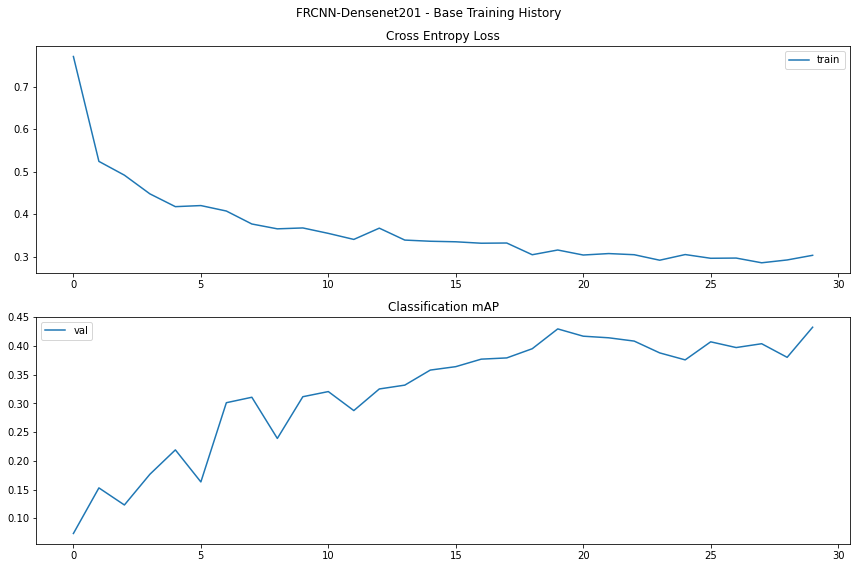

In [17]:
fig = plot_training_history(train_history=train_loss_history, val_history=val_map_history, model_name=MODEL_NAME, phase_name="Base Training", out_dir=OUT_DIR)
fig.show()

In [16]:
import gc
model = None

gc.collect()
torch.cuda.empty_cache()
torch.cuda.mem_get_info(device)

(3543112091, 4294836224)

In [17]:
!nvidia-smi

Sun Jun 12 08:45:43 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 512.95       Driver Version: 512.95       CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:01:00.0 Off |                  N/A |
| N/A   58C    P0    N/A /  N/A |     39MiB /  4096MiB |      1%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Fine-tune the predictor

In [18]:
best_checkpoint = torch.load(f"{OUT_DIR}/{MODEL_NAME}_best_model.pth")
model = get_model(n_classes=N_CLASSES)
model.load_state_dict(best_checkpoint["model"])
best_checkpoint = None

model.to(device)


print("Loaded best model...")

Loaded best model...


In [19]:
ft_optimizer = optim.Adam(
    params=model.parameters(),
    lr=1e-4,
    betas=(0.9, 0.999),
    weight_decay=5e-4,
    amsgrad=True
)

ft_lr_scheduler = optim.lr_scheduler.ExponentialLR(
    optimizer=ft_optimizer,
    gamma=0.9
)

In [22]:
FT_NUM_EPOCHS = 15
model.backbone.requires_grad_(False) # Keep backbone frozen
model.rpn.requires_grad_(True)
model.roi_heads.requires_grad_(True)

ft_train_loss_history = []

ft_val_map_history = []

ft_best_map = best_map
ft_best_epoch = -1

print(f"Starting {MODEL_NAME} fine-tuning...")

for epoch in range(1, FT_NUM_EPOCHS + 1):
    print(f"Epoch[{epoch}/{FT_NUM_EPOCHS}]")

    train_loss = train_epoch_iter(
        dataloader=train_dataloader,
        model=model,
        device=device,
        optimizer=ft_optimizer,
        lr_scheduler=ft_lr_scheduler
    )

    print(f"Training loss: {train_loss:.3f}")

    val_target, val_preds, _ = eval_epoch_iter(
        dataloader=val_dataloader,
        model=model,
        device=device
    )

    metric_scorer = get_metric_scorer()
    
    metric_scorer.update(val_preds, val_target)
    # Only present mAP for simplicity
    val_map = metric_scorer.compute()["map"].item()
    print(f"Validation mAP: {val_map:3f}")

    # Save best model
    if val_map > ft_best_map:
        ft_best_map = val_map
        ft_best_epoch = epoch
        save_dict = {"model": model.state_dict(), "optimizer": optimizer.state_dict(), "lr_scheduler": lr_scheduler.state_dict(), "epoch": epoch}
        torch.save(save_dict, f"{OUT_DIR}/{MODEL_NAME}_ft_best_model.pth")

    # Save latest model
    save_dict = {"model": model.state_dict(), "optimizer": optimizer.state_dict(), "lr_scheduler": lr_scheduler.state_dict(), "epoch": epoch}
    torch.save(save_dict, f"{OUT_DIR}/{MODEL_NAME}_ft_latest_model.pth")

    # Save loss and mAP in history
    ft_train_loss_history.append(train_loss)

    ft_val_map_history.append(val_map)

    print("----------------------------------------------------------------")

print(
    f"\nFinished training..."
    f"\nBest epoch: {ft_best_epoch}\t Validation mAP on best epoch: {ft_best_map}"
)


Starting FRCNN-Densenet201 fine-tuning...
Epoch[1/15]


100%|██████████| 61/61 [01:48<00:00,  1.78s/it]


Training loss: 0.300


100%|██████████| 15/15 [00:28<00:00,  1.91s/it]


Validation mAP: 0.441740
----------------------------------------------------------------
Epoch[2/15]


100%|██████████| 61/61 [01:46<00:00,  1.74s/it]


Training loss: 0.296


100%|██████████| 15/15 [00:28<00:00,  1.89s/it]


Validation mAP: 0.420268
----------------------------------------------------------------
Epoch[3/15]


100%|██████████| 61/61 [01:54<00:00,  1.88s/it]


Training loss: 0.318


100%|██████████| 15/15 [00:26<00:00,  1.78s/it]


Validation mAP: 0.433914
----------------------------------------------------------------
Epoch[4/15]


100%|██████████| 61/61 [01:49<00:00,  1.79s/it]


Training loss: 0.284


100%|██████████| 15/15 [00:31<00:00,  2.10s/it]


Validation mAP: 0.410831
----------------------------------------------------------------
Epoch[5/15]


100%|██████████| 61/61 [01:51<00:00,  1.83s/it]


Training loss: 0.285


100%|██████████| 15/15 [00:31<00:00,  2.08s/it]


Validation mAP: 0.393802
----------------------------------------------------------------
Epoch[6/15]


100%|██████████| 61/61 [01:46<00:00,  1.75s/it]


Training loss: 0.301


100%|██████████| 15/15 [00:28<00:00,  1.91s/it]


Validation mAP: 0.429176
----------------------------------------------------------------
Epoch[7/15]


100%|██████████| 61/61 [01:51<00:00,  1.83s/it]


Training loss: 0.288


100%|██████████| 15/15 [00:32<00:00,  2.13s/it]


Validation mAP: 0.427364
----------------------------------------------------------------
Epoch[8/15]


100%|██████████| 61/61 [01:44<00:00,  1.72s/it]


Training loss: 0.288


100%|██████████| 15/15 [00:32<00:00,  2.17s/it]


Validation mAP: 0.397002
----------------------------------------------------------------
Epoch[9/15]


100%|██████████| 61/61 [01:48<00:00,  1.78s/it]


Training loss: 0.287


100%|██████████| 15/15 [00:28<00:00,  1.89s/it]


Validation mAP: 0.419142
----------------------------------------------------------------
Epoch[10/15]


100%|██████████| 61/61 [01:53<00:00,  1.86s/it]


Training loss: 0.288


100%|██████████| 15/15 [00:27<00:00,  1.82s/it]


Validation mAP: 0.398973
----------------------------------------------------------------
Epoch[11/15]


100%|██████████| 61/61 [01:48<00:00,  1.77s/it]


Training loss: 0.283


100%|██████████| 15/15 [00:31<00:00,  2.13s/it]


Validation mAP: 0.431252
----------------------------------------------------------------
Epoch[12/15]


100%|██████████| 61/61 [01:47<00:00,  1.76s/it]


Training loss: 0.277


100%|██████████| 15/15 [00:32<00:00,  2.17s/it]


Validation mAP: 0.385338
----------------------------------------------------------------
Epoch[13/15]


100%|██████████| 61/61 [01:50<00:00,  1.81s/it]


Training loss: 0.277


100%|██████████| 15/15 [00:27<00:00,  1.84s/it]


Validation mAP: 0.409816
----------------------------------------------------------------
Epoch[14/15]


100%|██████████| 61/61 [01:46<00:00,  1.75s/it]


Training loss: 0.287


100%|██████████| 15/15 [00:32<00:00,  2.18s/it]


Validation mAP: 0.401076
----------------------------------------------------------------
Epoch[15/15]


100%|██████████| 61/61 [01:49<00:00,  1.79s/it]


Training loss: 0.293


100%|██████████| 15/15 [00:29<00:00,  1.95s/it]


Validation mAP: 0.439213
----------------------------------------------------------------

Finished training...
Best epoch: 1	 Validation mAP on best epoch: 0.44173991680145264


C:\Users\telmo\AppData\Local\Temp/ipykernel_2532/2489869928.py:2: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


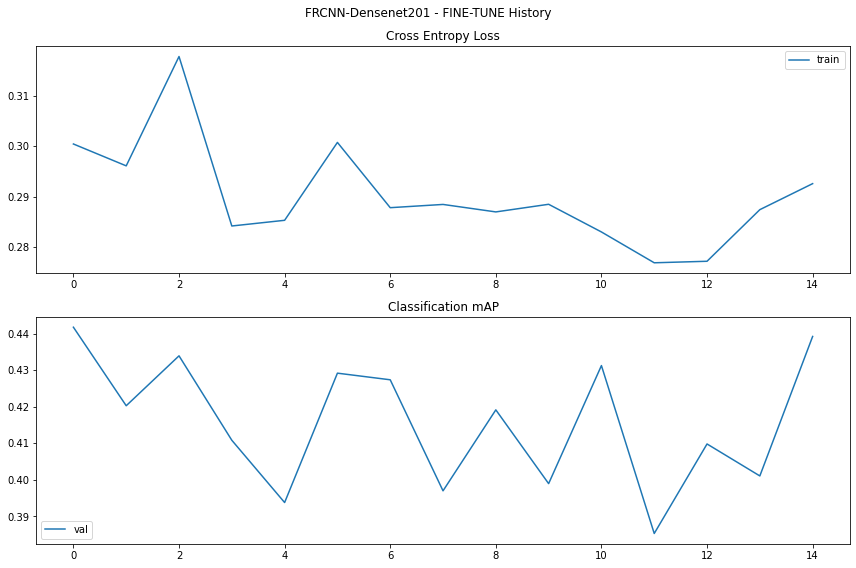

In [23]:
fig = plot_training_history(train_history=ft_train_loss_history, val_history=ft_val_map_history, model_name=MODEL_NAME, phase_name="FINE-TUNE", out_dir=OUT_DIR)
fig.show()

In [24]:
import gc
model = None

gc.collect()
torch.cuda.empty_cache()
torch.cuda.mem_get_info(device)

(2468518299, 4294836224)

In [25]:
!nvidia-smi

Sun Jun 12 09:37:05 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 512.95       Driver Version: 512.95       CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:01:00.0 Off |                  N/A |
| N/A   42C    P8    N/A /  N/A |   1064MiB /  4096MiB |      1%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Test Model

In [131]:
# Apply NMS on outputs
from torchvision.ops import batched_nms
CONFIDENCE_TH = 0.5
NMS_IOU_TH = 0.30
NMS_IOS_TH = 0.7

def nms_ios(boxes, labels): # Assume they're sorted already in descending scores
    indices = []
    for i in range(len(boxes) - 1, -1, -1):
        box_lower = boxes[i]
        x0i, y0i, x1i, y1i = box_lower[0].item(), box_lower[1].item(), box_lower[2].item(), box_lower[3].item()
        area_lower = abs(x1i-x0i) * abs(y1i-y0i)
        label_lower = labels[i]

        return_box = True

        for j in range(0, i):
            label_higher = labels[j]
            if label_lower != label_higher: # Ignore boxes that aren't from same class
                continue

            box_higher = boxes[j]
            x0j, y0j, x1j, y1j = box_higher[0].item(), box_higher[1].item(), box_higher[2].item(), box_higher[3].item()

            # Calculate intersection area
            xx0 = max(x0i, x0j)
            yy0 = max(y0i, y0j)
            xx1 = min(x1i, x1j)
            yy1 = min(y1i, y1j)
            w = max(0, xx1 - xx0)
            h = max(0, yy1 - yy0)
            intersection_area = w * h

            # Calculate intersection over Self (overlap percentage)
            IoS = intersection_area / area_lower

            if IoS > NMS_IOS_TH:
                return_box = False
                break
        
        if return_box:
            indices.append(i)

    return torch.tensor(list(reversed(indices))).to(boxes.get_device())

def test_epoch_iter(dataloader, model, device):
    model.eval()

    preds = []
    expected_labels = []
    imageIds = []

    with torch.set_grad_enabled(False):
        for _batch, (X, y) in enumerate(tqdm(dataloader)):
            X = list(x.to(device) for x in X)

            with torch.cuda.amp.autocast():
                outputs = model(X)

            for annotation in y:
                imageIds.append(annotation.pop("imageId").item())
                annotation.pop("areas")

            # Apply NMS & Confidence thresholds
            nms_conf_outputs = []
            for output in outputs:
                indices = batched_nms(boxes=output["boxes"], scores=output["scores"], idxs=output["labels"], iou_threshold=NMS_IOU_TH)
                nms_scores = torch.index_select(input=output["scores"], dim=0, index=indices)
                nms_boxes = torch.index_select(input=output["boxes"], dim=0, index=indices)
                nms_labels = torch.index_select(input=output["labels"], dim=0, index=indices)

                indices = nms_ios(boxes=nms_boxes, labels=nms_labels).to(device)
                nms_scores = torch.index_select(input=nms_scores, dim=0, index=indices)
                nms_boxes = torch.index_select(input=nms_boxes, dim=0, index=indices)
                nms_labels = torch.index_select(input=nms_labels, dim=0, index=indices)

                confidence_indices = (nms_scores > CONFIDENCE_TH).nonzero(as_tuple=True)[0]

                nms_conf_outputs.append({
                    "boxes": torch.index_select(input=nms_boxes, dim=0, index=confidence_indices),
                    "scores": torch.index_select(input=nms_scores, dim=0, index=confidence_indices),
                    "labels": torch.index_select(input=nms_labels, dim=0, index=confidence_indices)
                })

            # Put everything in CPU for safety
            nms_conf_outputs = [ {k: v.detach().cpu() for k, v in o.items()} for o in nms_conf_outputs ]
            y = [ {k: v.detach().cpu() for k, v in annotation.items()} for annotation in y]

            preds.extend(nms_conf_outputs)
            expected_labels.extend(y)
            
    return expected_labels, preds, imageIds

In [78]:
best_checkpoint = torch.load(f"{OUT_DIR}/{MODEL_NAME}_ft_best_model.pth")
model = get_model(n_classes=N_CLASSES)
model.load_state_dict(best_checkpoint["model"])
best_checkpoint = None

model.to(device)


print("Loaded best fine-tuned model...")

Loaded best fine-tuned model...


In [132]:
test_target, test_preds, test_ids = test_epoch_iter(
    dataloader=test_dataloader,
    model=model,
    device=device,
)

100%|██████████| 264/264 [01:31<00:00,  2.90it/s]


In [133]:
metric_scorer = MeanAveragePrecision(box_format="xyxy", class_metrics=True)
    
metric_scorer.update(test_preds, test_target)
# Only present mAP for simplicity
metrics = metric_scorer.compute()

metrics

{'map': tensor(0.5214),
 'map_50': tensor(0.7724),
 'map_75': tensor(0.5832),
 'map_small': tensor(0.2069),
 'map_medium': tensor(0.6657),
 'map_large': tensor(0.5283),
 'mar_1': tensor(0.5240),
 'mar_10': tensor(0.5629),
 'mar_100': tensor(0.5629),
 'mar_small': tensor(0.2361),
 'mar_medium': tensor(0.7129),
 'mar_large': tensor(0.5966),
 'map_per_class': tensor([0.2492, 0.7142, 0.4752, 0.6471]),
 'mar_100_per_class': tensor([0.3265, 0.7491, 0.4983, 0.6778])}

In [134]:
import cv2

os.makedirs(f"{OUT_DIR}/images", exist_ok=True)

def hex2rgb(h):  # rgb order
    return tuple(int(h[1 + i:1 + i + 2], 16) for i in (0, 2, 4))

colors = [hex2rgb(hex) for hex in ('#FF3838', '#FF9D97', '#FF701F', '#FFB21D', '#CFD231', '#48F90A', '#92CC17', '#3DDB86', '#1A9334', '#00D4BB',
            '#2C99A8', '#00C2FF', '#344593', '#6473FF', '#0018EC', '#8438FF', '#520085', '#CB38FF', '#FF95C8', '#FF37C7')]
line_width = 1

def label_image(outputs, id):
    image = cv2.imread(f"{IMG_DIR}/road{id}.png")
    # Annotation code taken from https://github.com/ultralytics/yolov5/ for consistency between YOLO and FRCNN outputs
    for label, box, score in zip(outputs["labels"], outputs["boxes"], outputs["scores"]):
        label = f"{label_decode_map[label.item()]} {score:.2f}"
        p1, p2 = (int(box[0]), int(box[1])), (int(box[2]), int(box[3]))
        color = colors[np.random.choice(range(len(colors)))]
        color = (color[2], color[1], color[0])

        cv2.rectangle(image, p1, p2, color, thickness=line_width, lineType=cv2.LINE_AA)
        tf = max(line_width - 1, 1)  # font thickness
        w, h = cv2.getTextSize(label, 0, fontScale=line_width / 3, thickness=tf)[0]  # text width, height
        outside = p1[1] - h >= 3
        p2 = p1[0] + w, p1[1] - h - 3 if outside else p1[1] + h + 3
        cv2.rectangle(image, p1, p2, color, -1, cv2.LINE_AA)  # filled
        cv2.putText(image,
                    label, (p1[0], p1[1] - 2 if outside else p1[1] + h + 2),
                    0,
                    line_width / 3,
                    (255, 255, 255),
                    thickness=tf,
                    lineType=cv2.LINE_AA)
        
    cv2.imwrite(f"{OUT_DIR}/images/road{id}.png", image)

In [135]:
for output, id in zip(test_preds, test_ids):
    label_image(output, id)